# Project 04 — ETA Prediction (Regression Model)

This notebook implements a regression pipeline to predict delivery ETA (Estimated Time of Arrival) using a synthetic logistics-like dataset.
It follows the internal Applied ML workflow:
- data loading and exploratory analysis
- preprocessing and feature engineering
- baseline regression models
- model comparison
- evaluation using MAE, RMSE, and R²
- business-oriented insights


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Optional: XGBoost
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False

sns.set(style="whitegrid")
RANDOM_STATE = 42


In [2]:
# Synthetic ETA-like dataset for initial development

n_samples = 5000
n_features = 5

X, y = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    noise=15.0,
    random_state=RANDOM_STATE
)

feature_cols = [
    "distance_km",
    "package_weight",
    "traffic_index",
    "pickup_hour",
    "delivery_priority"
]

df = pd.DataFrame(X, columns=feature_cols)

# Transform features to look more realistic
df["distance_km"] = np.abs(df["distance_km"]) * 5
df["package_weight"] = np.abs(df["package_weight"]) * 2
df["traffic_index"] = np.clip(np.abs(df["traffic_index"]), 0, 10)
df["pickup_hour"] = np.clip(np.abs(df["pickup_hour"]) % 24, 0, 23)
df["delivery_priority"] = np.clip(np.round(np.abs(df["delivery_priority"])), 0, 2)

# Create a positive ETA in minutes
eta_minutes = np.abs(y) / 5 + 10  # keep it positive and in a reasonable range
df["eta_minutes"] = eta_minutes

df.head()


,distance_km,package_weight,traffic_index,pickup_hour,delivery_priority,eta_minutes
0,0.623893,0.515723,1.189283,1.333439,2.0,61.844763
1,2.301195,3.391225,0.202300,2.421955,1.0,23.143491
2,1.287909,2.601470,0.185878,0.636180,0.0,13.495333
3,3.018907,3.030636,0.701390,0.845273,1.0,40.720458
4,4.589881,3.462339,0.368939,0.213809,2.0,40.679123


In [16]:
import os

# Garante que a pasta data/ existe
os.makedirs("data", exist_ok=True)

DATA_PATH = "data/eta_dataset.csv"

# Salva o DataFrame df como CSV
df.to_csv(DATA_PATH, index=False)
print(f"Dataset saved to {DATA_PATH} with shape {df.shape}")


Dataset saved to data/eta_dataset.csv with shape (5000, 6)


In [18]:
import os

# === Configuration ===========================================================
DATA_PATH = "data/eta_dataset.csv"   # ajuste o caminho para o seu CSV real
USE_SYNTHETIC_FALLBACK = False        # se False, levanta erro se o arquivo não existir

# Colunas que esperamos encontrar no dataset real
REQUIRED_COLUMNS = [
    "distance_km",
    "package_weight",
    "traffic_index",
    "pickup_hour",
    "delivery_priority",
    "eta_minutes",    # target
]

# === Loader + validation =====================================================
def load_eta_dataset(
    data_path: str = DATA_PATH,
    required_columns=None,
    use_synthetic_fallback: bool = True,
):
    if required_columns is None:
        required_columns = REQUIRED_COLUMNS

    if os.path.exists(data_path):
        print(f"📂 Loading REAL ETA dataset from: {data_path}")
        df_real = pd.read_csv(data_path)

        # 1) Verificar se todas as colunas obrigatórias existem
        missing = [c for c in required_columns if c not in df_real.columns]
        if missing:
            raise ValueError(
                f"Missing required columns in real dataset: {missing}\n"
                f"Available columns: {list(df_real.columns)}"
            )

        # 2) Checagem rápida de nulos nessas colunas
        null_counts = df_real[required_columns].isna().sum()
        print("\n🔍 Null values in required columns:")
        print(null_counts)

        # 3) Algumas sanity checks simples (distância negativa etc.)
        if (df_real["distance_km"] < 0).any():
            print("⚠ Warning: negative values found in 'distance_km'.")

        if (df_real["eta_minutes"] <= 0).any():
            print("⚠ Warning: non-positive values found in 'eta_minutes'.")

        print(f"\n✅ Real dataset loaded successfully. Shape: {df_real.shape}")
        return df_real, "real"

    if use_synthetic_fallback:
        print(
            f"⚠ Real dataset NOT found at '{data_path}'. "
            "Using synthetic ETA dataset as fallback."
        )
        # Aqui assumimos que 'df' já foi criado pela célula sintética anterior.
        return df.copy(), "synthetic"

    # Se chegou aqui, não há dataset real nem fallback permitido
    raise FileNotFoundError(
        f"ETA dataset not found at '{data_path}' "
        "and synthetic fallback is disabled."
    )

# === Execute loader ==========================================================
df, data_source = load_eta_dataset()
print(f"\n📊 Data source in use: {data_source.upper()} (df shape: {df.shape})")

df.head()


📂 Loading REAL ETA dataset from: data/eta_dataset.csv

🔍 Null values in required columns:
distance_km          0
package_weight       0
traffic_index        0
pickup_hour          0
delivery_priority    0
eta_minutes          0
dtype: int64

✅ Real dataset loaded successfully. Shape: (5000, 6)

📊 Data source in use: REAL (df shape: (5000, 6))


,distance_km,package_weight,traffic_index,pickup_hour,delivery_priority,eta_minutes
0,0.623893,0.515723,1.189283,1.333439,2.0,61.844763
1,2.301195,3.391225,0.202300,2.421955,1.0,23.143491
2,1.287909,2.601470,0.185878,0.636180,0.0,13.495333
3,3.018907,3.030636,0.701390,0.845273,1.0,40.720458
4,4.589881,3.462339,0.368939,0.213809,2.0,40.679123


In [15]:
import os

os.makedirs("data", exist_ok=True)
DATA_PATH = "data/eta_dataset.csv"

df.to_csv(DATA_PATH, index=False)
print(f"Dataset saved to {DATA_PATH} with shape {df.shape}")


Dataset saved to data/eta_dataset.csv with shape (5000, 6)


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   distance_km        5000 non-null   float64
 1   package_weight     5000 non-null   float64
 2   traffic_index      5000 non-null   float64
 3   pickup_hour        5000 non-null   float64
 4   delivery_priority  5000 non-null   float64
 5   eta_minutes        5000 non-null   float64
dtypes: float64(6)
memory usage: 234.5 KB


In [4]:
df.describe()


,distance_km,package_weight,traffic_index,pickup_hour,delivery_priority,eta_minutes
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,3.956501,1.577716,0.785492,0.802360,0.762600,33.736735
std,2.991229,1.184512,0.608801,0.600501,0.679657,18.183958
min,0.002800,0.000627,0.000072,0.000161,0.000000,10.011218
25%,1.594761,0.630155,0.300822,0.324023,0.000000,19.232658
50%,3.329337,1.348653,0.652563,0.687028,1.000000,30.031528
75%,5.698154,2.261826,1.153550,1.156666,1.000000,44.366877
max,22.395421,7.712751,3.942331,3.635200,2.000000,131.759253


In [5]:
df.isna().sum()


distance_km          0
package_weight       0
traffic_index        0
pickup_hour          0
delivery_priority    0
eta_minutes          0
dtype: int64

In [6]:
# No missing values in this synthetic dataset
df_clean = df.copy()

target_col = "eta_minutes"
feature_cols = [col for col in df_clean.columns if col != target_col]

X = df_clean[feature_cols]
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)
X_train.shape, X_test.shape


((4000, 5), (1000, 5))

In [7]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)


In [8]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

gb = GradientBoostingRegressor(random_state=RANDOM_STATE)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)


In [9]:
if xgb_available:
    xgb = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE
    )
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
else:
    y_pred_xgb = None


In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(name, y_true, y_pred):
    # Garantir formato 1D numérico
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()

    mae = float(mean_absolute_error(y_true, y_pred))
    mse = float(mean_squared_error(y_true, y_pred))   # sem o parâmetro 'squared'
    rmse = mse ** 0.5                                 # RMSE = sqrt(MSE)
    r2 = float(r2_score(y_true, y_pred))

    print(f"{name}")
    print(f"  MAE : {mae:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  R²  : {r2:.3f}")
    print("-" * 40)


In [13]:
evaluate_model("Linear Regression", y_test, y_pred_lin)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("Gradient Boosting", y_test, y_pred_gb)

if y_pred_xgb is not None:
    evaluate_model("XGBoost", y_test, y_pred_xgb)


Linear Regression
  MAE : 12.790
  RMSE: 15.923
  R²  : 0.249
----------------------------------------
Random Forest
  MAE : 12.831
  RMSE: 16.219
  R²  : 0.220
----------------------------------------
Gradient Boosting
  MAE : 12.712
  RMSE: 15.916
  R²  : 0.249
----------------------------------------


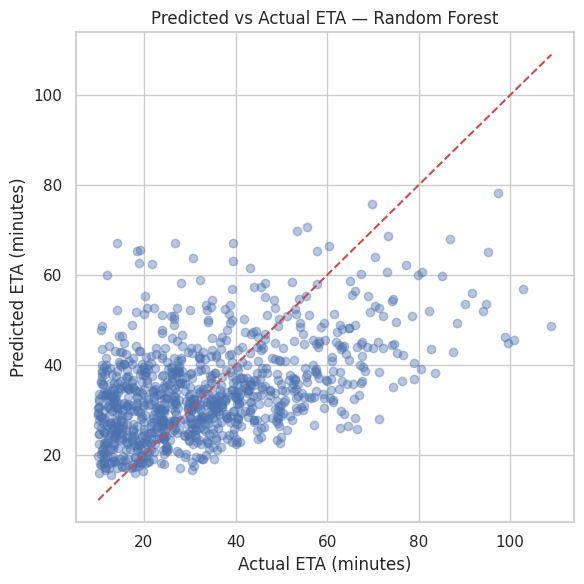

In [14]:
best_y_pred = y_pred_rf  # choose which model you want to visualize

plt.figure(figsize=(6, 6))
plt.scatter(y_test, best_y_pred, alpha=0.4)
plt.xlabel("Actual ETA (minutes)")
plt.ylabel("Predicted ETA (minutes)")
plt.title("Predicted vs Actual ETA — Random Forest")
min_eta = min(y_test.min(), best_y_pred.min())
max_eta = max(y_test.max(), best_y_pred.max())
plt.plot([min_eta, max_eta], [min_eta, max_eta], "r--")
plt.tight_layout()
plt.show()


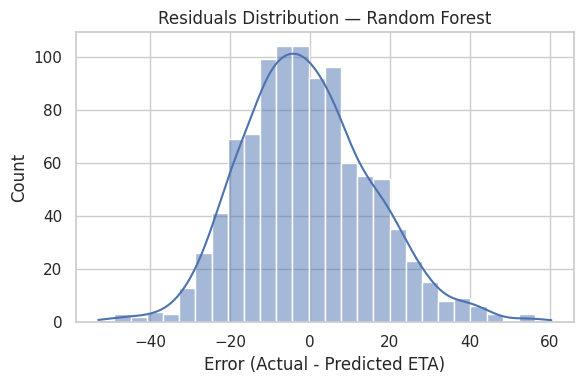

In [15]:
residuals = y_test - best_y_pred

plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution — Random Forest")
plt.xlabel("Error (Actual - Predicted ETA)")
plt.tight_layout()
plt.show()


# Business-Oriented Insights (Draft)

- A synthetic ETA dataset was used to prototype the regression pipeline.
- Multiple models were trained and compared using MAE, RMSE, and R².
- Error distributions and prediction vs actual plots were generated to support model assessment.
- Once the real ETA dataset is available, this pipeline can be adapted with:
  - real feature definitions,
  - proper train/validation splits,
  - and domain-specific error thresholds.
